# HumanBreastCancer (Visium) In Silico Knockout Tutorial

<p style="color:#1E90FF;">
<b>Note:</b> To run this notebook, please first complete and execute the <i>HumanBreastCancer (Visium) Analysis Tutorial</i> notebook and save the resulting output files as instructed.
</p>


In [1]:
from models.downstreamGenes import *
import numpy as np
import squidpy as sq
import scanpy as sc
import pickle
from models.help_func import build_cell_lr_tensor,set_seed
import matplotlib.pyplot as plt

set_seed(42)

/home/jtyu@ZHANGroup.local/miniconda3/envs/scild/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/jtyu@ZHANGroup.local/miniconda3/envs/scild/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Import data and SCILD results

In [2]:
adata = sc.read_h5ad('./data/HumanBreastCancerVisium_adata_Sprod.h5ad')

In [5]:
with open("./results/HumanBreastCancerVisium_SCILD_result.pkl", "rb") as f:
    SCILD_res = pickle.load(f)

In [7]:
SCILD_tensor, ligands, receptors = build_cell_lr_tensor(SCILD_res, adata.shape[0])
ligand_to_index = {lig: idx for idx, lig in enumerate(ligands)}
receptor_to_index = {rec: idx for idx, rec in enumerate(receptors)}

In [8]:
SCILD_tensor.shape

(3798, 45, 36)

## Train the NN model

Training Epochs:  31%|███       | 155/500 [01:03<02:22,  2.43it/s, Epoch=156, Train Loss=0.0029, Val Loss=0.0027, LR=0.000250]

Early stopping at epoch 157


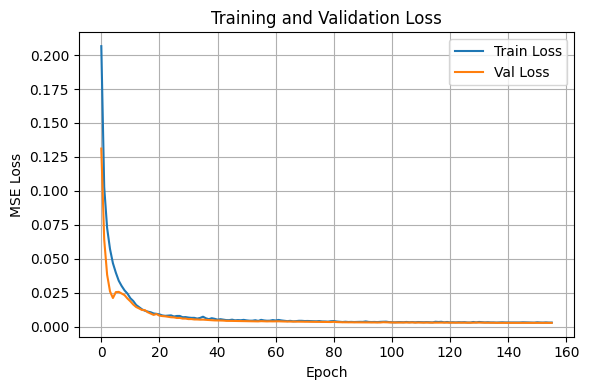

In [9]:
model = train_model(
    SCILD_tensor,
    Y=adata.X.A,
    hidden_dim=64,
    epochs=500,
    batch_size=256,
    lr=1e-3,
    val_split=0.2,
    patience=20
)

## Selection L-Rs of interset

In [10]:
from models.help_func import build_adata_from_ccc_send_receive

SCILD_CCC_adata = build_adata_from_ccc_send_receive(SCILD_res)
SCILD_CCC_adata.obsm["spatial"] = adata.obsm["spatial"]
SCILD_CCC_adata.obs.index = adata.obs.index

In [11]:
from models.help_func import compute_spatial_autocorrelation

moran_df = compute_spatial_autocorrelation(SCILD_CCC_adata)
moran_df = moran_df.sort_values('moran_I', ascending=False)
moran_df.head()

moran_I  p_value
IL6_IL6ST_receive     0.956677      0.0
CXCL2_ACKR1_receive   0.933459      0.0
TGFB2_ACVR1B_receive  0.922643      0.0
FGF5_FGFR1_receive    0.910162      0.0
AREG_ERBB2_receive    0.909412      0.0

In [12]:
from models.help_func import rank_genes_by_total_signal

totalsignal_df = rank_genes_by_total_signal(SCILD_CCC_adata)
totalsignal_df = totalsignal_df.sort_values('total_signal', ascending=False)
totalsignal_df.head()

total_signal
CXCL12_CXCR4_send       647.624206
CXCL12_CXCR4_receive    647.624206
CXCL12_ACKR3_send       591.037468
CXCL12_ACKR3_receive    591.037468
CXCL9_ACKR1_send        336.197911

In [13]:
from models.help_func import dict_to_ccc_dataframe_CT, compute_intra_inter_mean

grouped_df = dict_to_ccc_dataframe_CT(SCILD_res, list(adata.obs['region']), list(adata.obs.index))
grouped_df2 = compute_intra_inter_mean(grouped_df)
grouped_df2 = grouped_df2.sort_values('inter', ascending=False)
grouped_df2.head()

intra     inter
CXCL12_CXCR4  0.000182  0.000023
CXCL12_ACKR3  0.000153  0.000021
CXCL11_ACKR3  0.000086  0.000012
CXCL9_ACKR1   0.000074  0.000010
TGFB1_ACVR1B  0.000068  0.000009

In [14]:
grouped_df.loc['Tumor margin'].loc['SI margin'].sort_values( ascending=False).head(10)

CXCL12_CXCR4    0.000076
CXCL12_ACKR3    0.000067
CXCL9_ACKR1     0.000051
CXCL11_ACKR3    0.000045
CXCL9_CXCR3     0.000036
TGFB1_TGFBR2    0.000032
VEGFA_KDR       0.000030
TGFB1_TGFBR1    0.000028
TGFB1_ACVR1B    0.000027
CXCL10_ACKR1    0.000026
Name: SI margin, dtype: float64

In [15]:
grouped_df.loc['SI margin'].loc['Tumor margin'].sort_values( ascending=False).head(10)

CXCL12_CXCR4    0.000100
CXCL12_ACKR3    0.000087
CXCL11_ACKR3    0.000041
TGFB1_ACVR1B    0.000038
TGFB1_TGFBR1    0.000034
TGFB1_TGFBR2    0.000033
TGFB3_ACVR1B    0.000028
CXCL9_ACKR1     0.000028
VEGFA_KDR       0.000025
TGFB3_TGFBR1    0.000025
Name: Tumor margin, dtype: float64

plot

Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


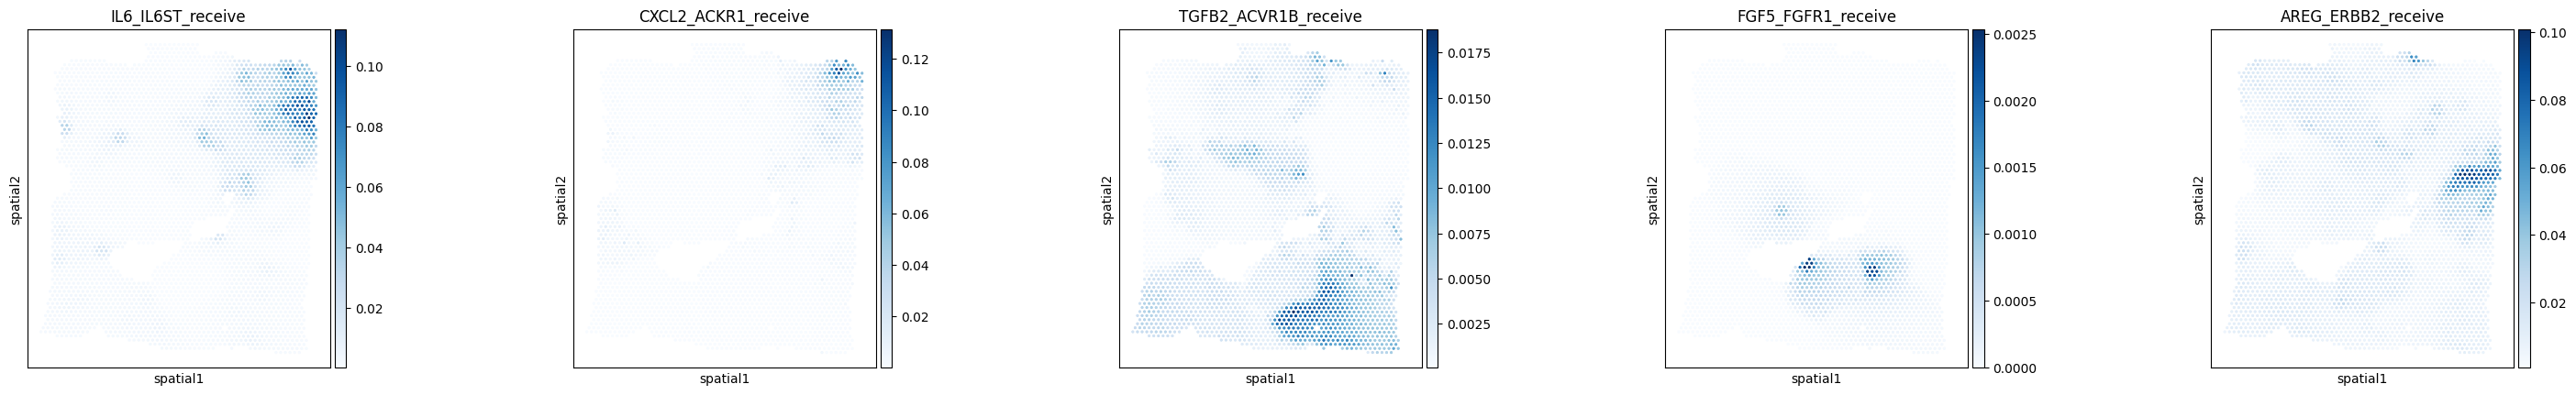

In [16]:
sq.pl.spatial_scatter(SCILD_CCC_adata, color=moran_df.head(5).index, cmap='Blues', shape=None, size=5, ncols=5)

Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


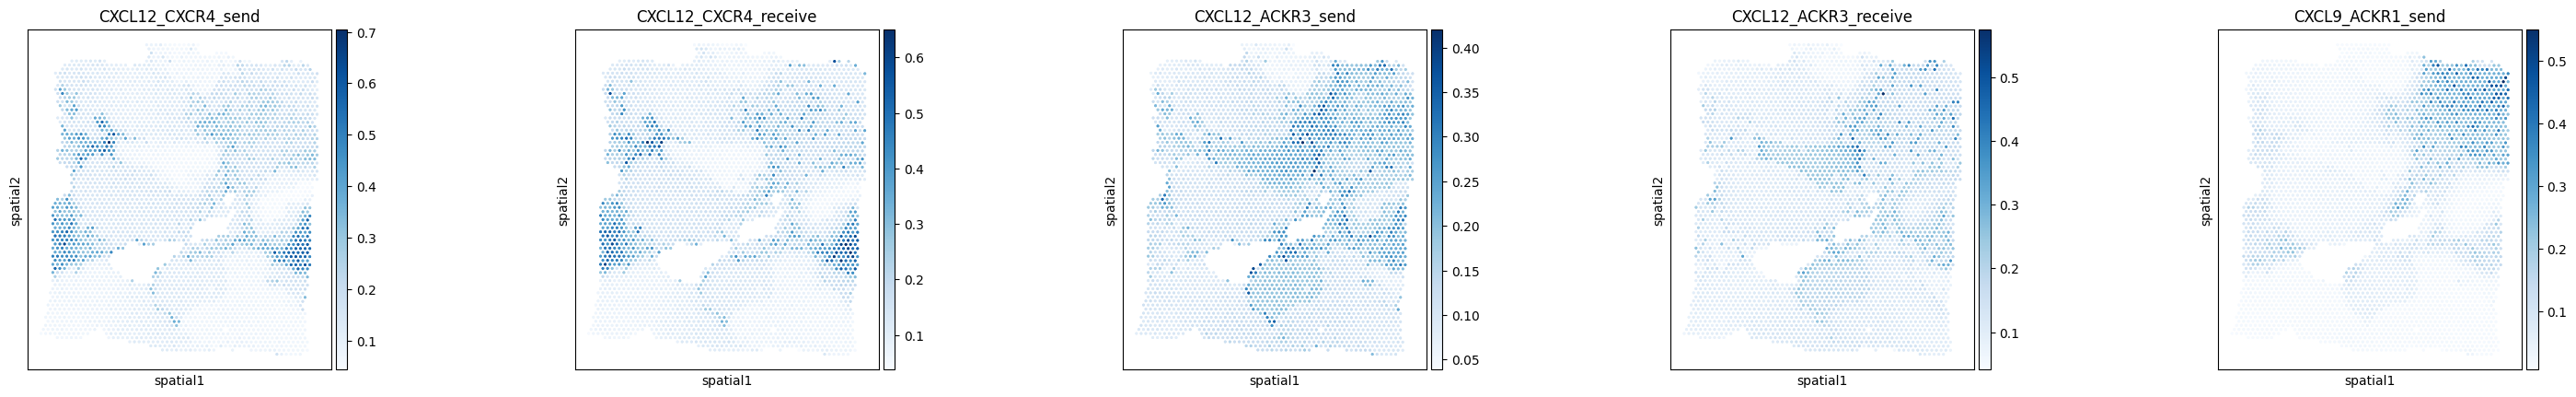

In [17]:
sq.pl.spatial_scatter(SCILD_CCC_adata, color=totalsignal_df.head(5).index, cmap='Blues', shape=None, size=5, ncols=5)

Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


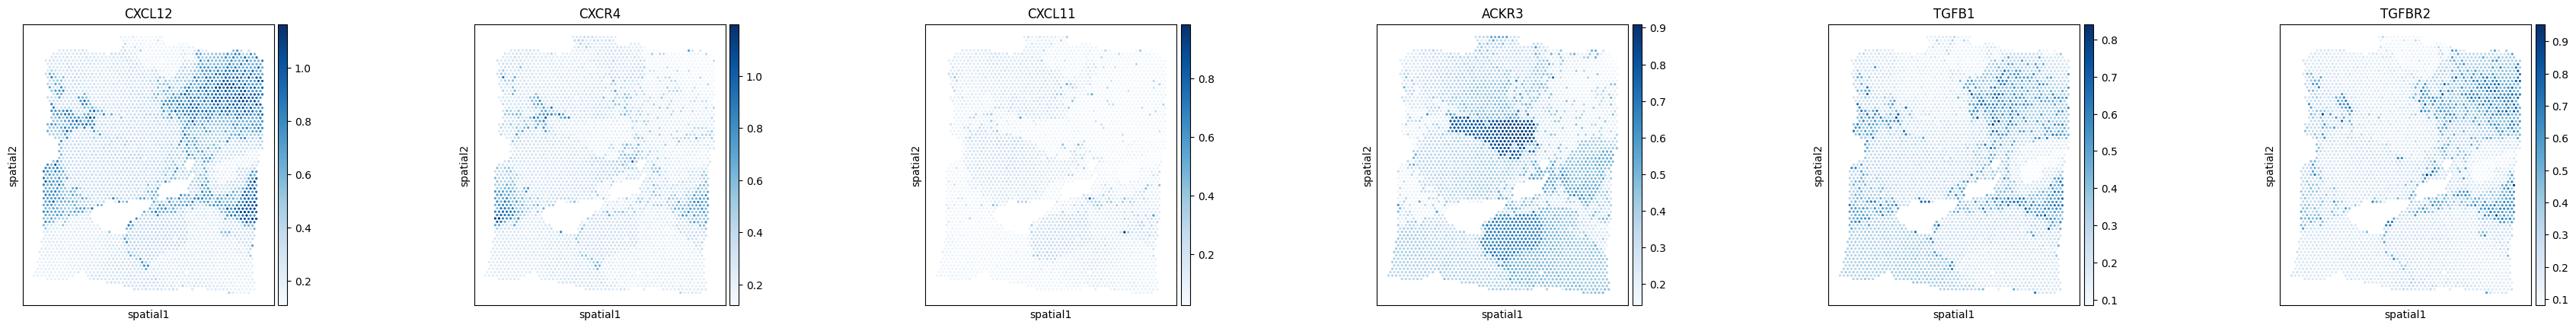

In [18]:
sq.pl.spatial_scatter(adata, color=['CXCL12', 'CXCR4', 'CXCL11', 'ACKR3', 'TGFB1', 'TGFBR2'], cmap='Blues', shape=None, size=5, ncols=6)

## In silico knockout of CXCL12->ACKR3


Top 10 affected genes (by magnitude) after ablating L=5, R=1:
1. CXCL14 — Δexpr = -0.0562 ↓
2. CPB1 — Δexpr = +0.0509 ↑
3. CSTA — Δexpr = +0.0491 ↑
4. SCGB1D2 — Δexpr = +0.0460 ↑
5. S100G — Δexpr = +0.0449 ↑
6. SCGB2A2 — Δexpr = +0.0439 ↑
7. CRISP3 — Δexpr = -0.0426 ↓
8. KRT8 — Δexpr = -0.0407 ↓
9. DEGS1 — Δexpr = -0.0372 ↓
10. RPL8 — Δexpr = -0.0369 ↓

Top 5 Upregulated Genes:
1. CPB1 — Δexpr = +0.0509 ↑
2. CSTA — Δexpr = +0.0491 ↑
3. SCGB1D2 — Δexpr = +0.0460 ↑
4. S100G — Δexpr = +0.0449 ↑
5. SCGB2A2 — Δexpr = +0.0439 ↑

Top 5 Downregulated Genes:
1. CXCL14 — Δexpr = -0.0562 ↓
2. CRISP3 — Δexpr = -0.0426 ↓
3. KRT8 — Δexpr = -0.0407 ↓
4. DEGS1 — Δexpr = -0.0372 ↓
5. RPL8 — Δexpr = -0.0369 ↓


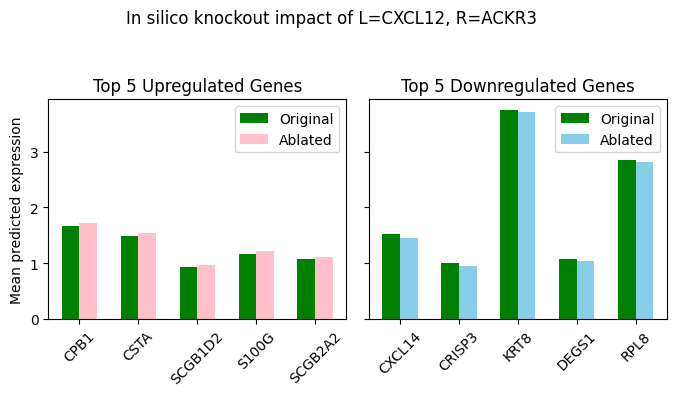

In [20]:
ligand_ = "CXCL12"
receptor_ =  "ACKR3"
TG_name = list(adata.var.index)
ablation_results = ablation_analysis(
    model, 
    SCILD_tensor, 
    l_idx=ligand_to_index[ligand_], 
    r_idx=receptor_to_index[receptor_], 
    gene_names=TG_name,
    title_=f"In silico knockout impact of L={ligand_}, R={receptor_}",
    save_file='./results/HumanBreastCancerVisium_InSilicoKnockout_CXCL12ACKR3_result.svg')

Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


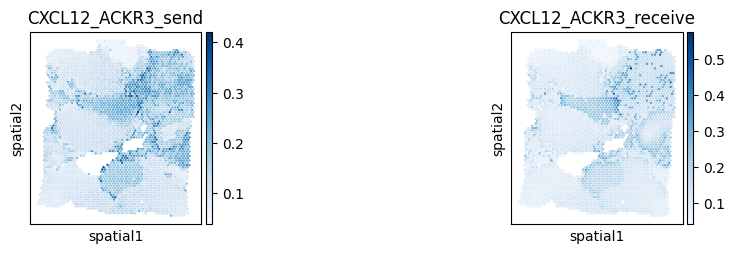

In [21]:
sq.pl.spatial_scatter(SCILD_CCC_adata, color=[f'{ligand_}_{receptor_}_send', f'{ligand_}_{receptor_}_receive'], cmap='Blues', shape=None, size=1, figsize=(5, 2.5))

Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


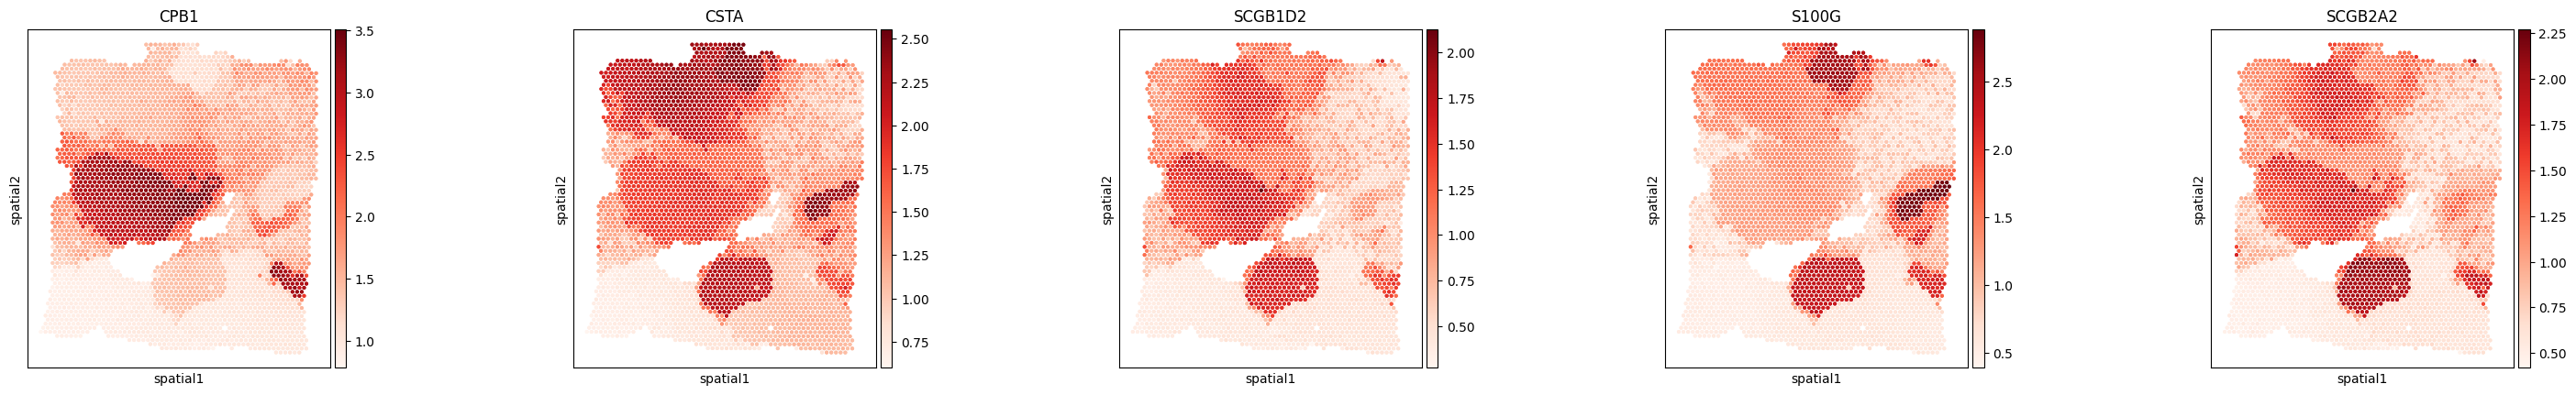

In [22]:
sq.pl.spatial_scatter(adata, color=[TG_name[i] for i in ablation_results['top_up_idx']], cmap='Reds', shape=None, size=15, ncols=5)

Please specify a valid `library_id` or set it permanently in `adata.uns['spatial']`


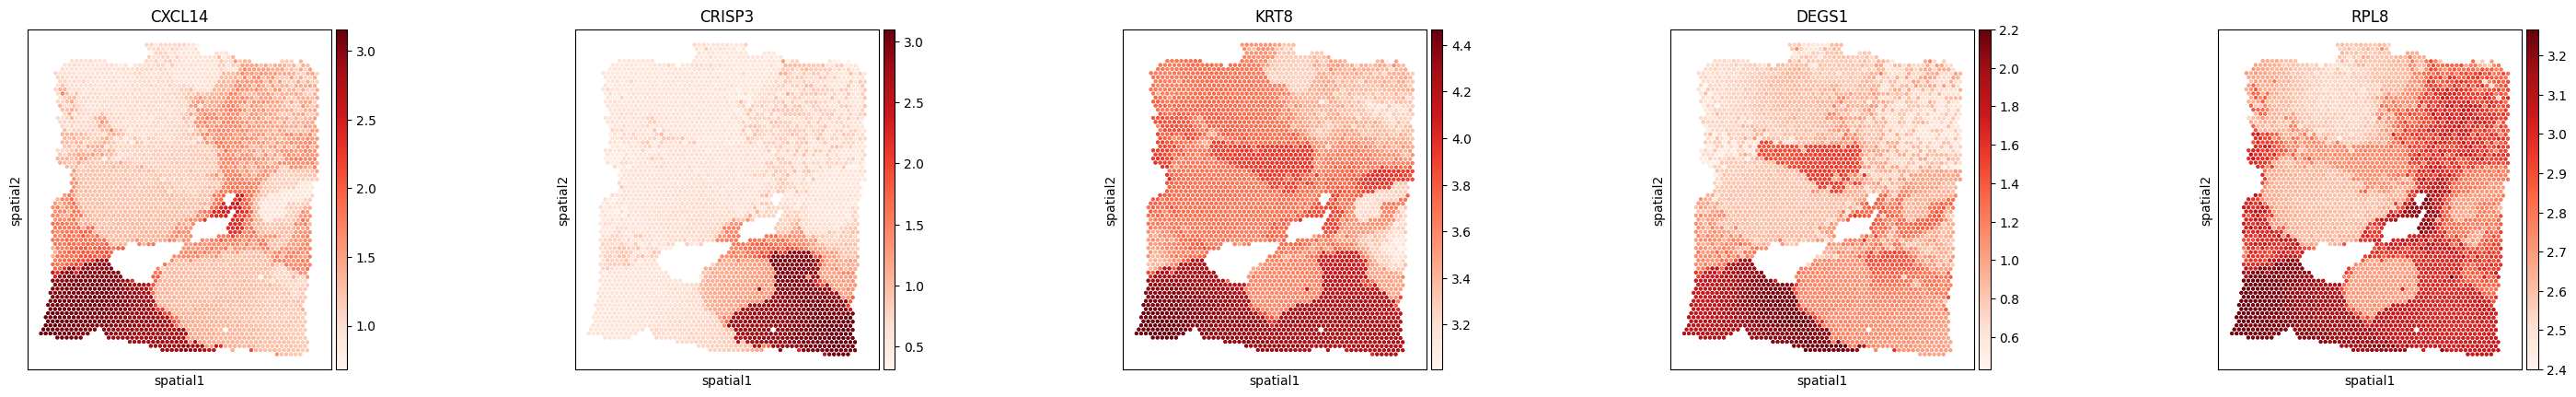

In [23]:
sq.pl.spatial_scatter(adata, color=[TG_name[i] for i in ablation_results['top_down_idx']], cmap='Reds', shape=None, size=15, ncols=5)